# ДЗ-1. Выкачивание постов и комментариев сообщества                                                            вконтакте

*Ася Симонян, БКЛ-152* (сообщество https://vk.com/vk_moscow)

Предустановки

In [11]:
import requests
import json
import re
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') 

from collections import Counter

In [12]:
def vk_api(method, **kwargs):
    api_request = 'https://api.vk.com/method/'+method + '?'
    api_request += '&'.join(['{}={}'.format(key, kwargs[key]) for key in kwargs])
    return json.loads(requests.get(api_request).text)

In [13]:
group_info = vk_api('groups.getById', group_id='vk_moscow', v='5.63')
group_id = group_info['response'][0]['id']
#group_id

Выкачиваем посты

In [14]:
posts = []
item_count = 120
result = vk_api('wall.get', owner_id=-group_id, v='5.63', count=100)
posts += result["response"]["items"]
while len(posts) < item_count:
    result = vk_api('wall.get', owner_id=-group_id, v='5.63', count=100, offset=len(posts))
    posts += result['response']["items"]

Выкачиваем информацию по комментариям к посту

In [15]:
def comm_get(post, n):
    comm_info = []
    result = vk_api('wall.getComments', owner_id=-group_id, post_id=post, v='5.63', count=100)
    comm_info += result["response"]['items']
    if n > 100:
        while len(comm_info) < n:
            result = vk_api('wall.getComments', owner_id=-group_id, post_id=post, v='5.63', count=100, offset=len(comm_info))
            comm_info += result['response']["items"]
    return comm_info

Записываем информацию в файл. Перед текстом поста будет пометка <\post_text>,
перед текстом комментария - <\comment_text>

In [16]:
def write_file(item, item_type):
    with open('InteresnayaMoskva.txt', 'a', encoding='UTF-8') as f:
        f.write(item_type + item)

Считаем количество слов

In [17]:
def len_count(item):
    text = item['text']
    reg = re.compile('[^а-яёА-ЯЁ0-9a-zA-Z]+', flags=re.U | re.DOTALL)
    text = re.sub(reg, ' ', text)
    words = text.split(' ')
    item_len = len(words)
    return item_len

Добудем доступную нам информацию о комментаторе (посты в этой группы никогда не публикуются от именни пользователя, так что об авторе поста собирать информацию не получится)

In [18]:
gr1_data = {}
gr2_data = []

In [19]:
import datetime
def user_info(u_id, dt):
    result = vk_api('users.get', user_ids=u_id, fields='bdate,city', v='5.63')
    user = result['response'][0]
    if 'bdate' in user and len(user['bdate']) >= 9:
        a = datetime.datetime.fromtimestamp(dt).strftime('%Y-%m-%d %H:%M:%S')
        if a[5] == '0':
            comm_date = a[8:10] + '.' + a[6:7] +'.' + a[:4]
        else:
            comm_date = a[8:10] + '.' + a[5:7] +'.' + a[:4]
        comm = comm_date.split('.')
        birth = user['bdate'].split('.')
        #print('comm', comm[1:], 'birth', birth[1:])
        if int(comm[1]) < int(birth[1]):
            age = int(comm[2]) - int(birth[2]) - 1
        else:
            age = int(comm[2]) - int(birth[2])
    else:
        age = ''
    if 'city' in user:
        city = user['city']['title']
    else:
        city = ''
    return age, city

In [20]:
i = 1
for post in posts:
    try:
        postlen = len_count(post)
        comm_n = post['comments']['count']
        post_id = post['id']
        comment_info = comm_get(post_id, comm_n)
        write_file(post['text'], '\n<post_text>\n')
        if postlen not in gr1_data:
            gr1_data[postlen] = []
        for item in comment_info:
            commlen = len_count(item)
            if item['text'] != '':
                write_file(item['text'], '\n<comment_text>\n')
            age, city = user_info(item['from_id'], item['date'])
            gr1_data[postlen].append(commlen)
            gr2_data.append([commlen, age, city])
    except IndexError:
        continue
    print('i', end=' ')
    i += 1

i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i 

Построим первый график

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 30, 33, 35, 36, 41, 42, 44, 52, 57, 58, 59, 60, 83, 85, 103, 110, 111, 118, 119, 126, 129, 160, 191, 195, 229, 294, 432, 472, 474, 496, 503, 513, 536, 551, 571] [7.603053435114504, 10.582417582417582, 9.320557491289199, 14.548387096774194, 4.923606168446026, 13.182054616384915, 10.131782945736434, 15.545454545454545, 3.199575371549894, 10.467625899280575, 25.34, 7.697478991596639, 8.222042663219133, 10.8125, 11.615384615384615, 4.549248747913189, 15.54601226993865, 13.9, 11.482758620689655, 9.934017595307918, 8.706467661691542, 14.045454545454545, 11.714285714285714, 9.727272727272727, 5.6571428571428575, 15.454545454545455, 30.559139784946236, 24.523809523809526, 5.833333333333333, 15.714285714285714, 9.121951219512194, 0, 10.0, 14.8, 14.606060606060606, 7.833333333333333, 2.0, 9.818181818181818, 5.916666666666667, 0, 5.5, 3.8, 0, 8.125, 0, 26.666666666666668, 24.51851851851852, 11.5, 6.6, 13.333333333

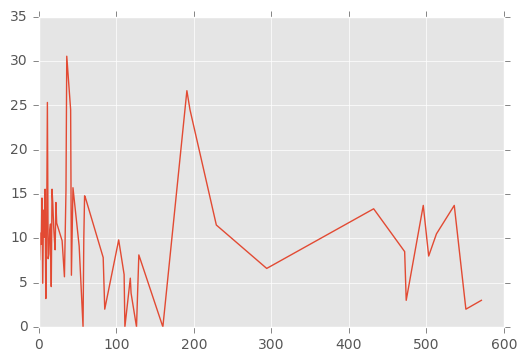

In [22]:
%matplotlib inline
p_lnths = sorted(list(gr1_data))
c_lnths = []
#???????arr = list(gr1_data)
for el in p_lnths:
    #p_lnths.append(el)
    if len(gr1_data[el]) != 0:
        c_lnths.append(sum(gr1_data[el])/len(gr1_data[el]))
    else:
        c_lnths.append(0)
print(p_lnths, c_lnths)
plt.plot(p_lnths, c_lnths)

Построем второй график

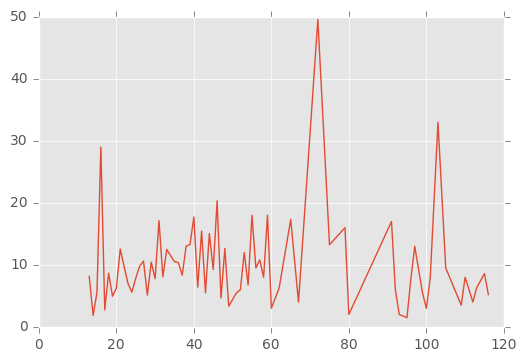

In [23]:
%matplotlib inline
d = {}
for el in gr2_data:
    #print(el)
    age = el[1]
    if age not in d:
        d[age] = []
    d[age].append(el[0])
d.pop('')
ages = sorted(list(d))
ca_lnths = []
for years in ages:
    ca_lnths.append(sum(d[years])/len(d[years]))
plt.plot(ages, ca_lnths)

Построим третий график

([<matplotlib.axis.XTick at 0x1e2bf43a908>,
 <a list of 435 Text xticklabel objects>)

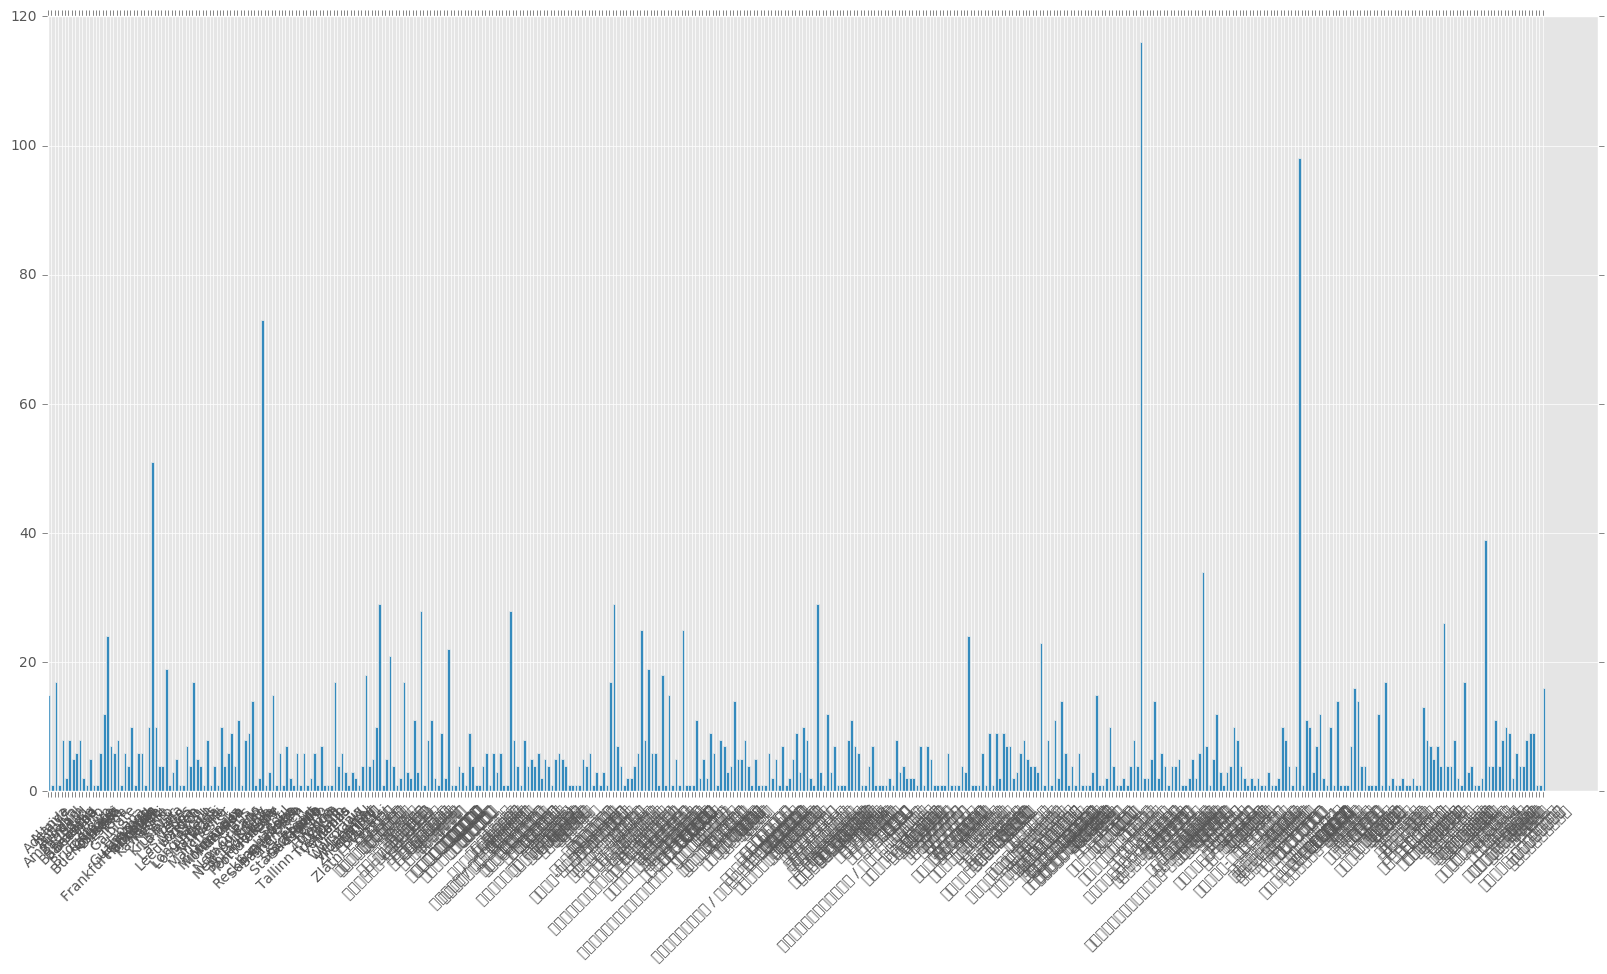

In [24]:
%matplotlib inline
d1 = {}
for el in gr2_data:
    if el[2] not in d:
        d1[el[2]] = []
    d1[el[2]].append(el[0])
d1.pop('')
cities = sorted(list(d1))
ca_lnths = []
for city in cities:
    ca_lnths.append(sum(d1[city])/len(d1[city]))
plt.figure(figsize=(20,10))
#cit = Counter([i for i in cities if i]).most_common(10)
plt.bar(range(len(cities)), ca_lnths)
plt.xticks(range(len(cities)), cities, rotation=45)